In [1]:
# LZ77 compression implementation (First part of the Deflate algorithm)

def find_longest_match(s, curr_pos, window_size, buffer_size):
    buffer_end = min(curr_pos + buffer_size, len(s))
    best_match_distance = 0
    best_match_length = 0
    
    for i in range(max(0, curr_pos - window_size), curr_pos):
        match_length = 0
        while (curr_pos + match_length < buffer_end and
               i + match_length < curr_pos and
               s[i + match_length] == s[curr_pos + match_length]):
            match_length += 1
        
        if match_length > best_match_length:
            best_match_distance = curr_pos - i
            best_match_length = match_length
    
    if best_match_length > 0:
        return (best_match_distance, best_match_length)
        
    return None
    
def lz77_encoding(s, window_size=2048, buffer_size=64):
    compressed = []
    i = 0
    while i < len(s):
        match = find_longest_match(s, i, window_size, buffer_size)
        if match:
            (jump, window_length) = match
            next_char = s[i + window_length] if i + window_length < len(s) else ''
            compressed.append((jump, window_length, next_char))
            i += window_length + 1
        else:
            compressed.append((0, 0, s[i]))
            i += 1
            
    return compressed

def lz77_decoding(compressed):
    decompressed = []
    for item in compressed:
        if item[0] == 0 and item[1] == 0:
            decompressed.append(item[2])
        else:
            jump, window_length, next_char = item
            for i in range(window_length):
                decompressed.append(decompressed[-jump])
            decompressed.append(next_char)
            
    return ''.join(decompressed)

In [2]:
# Huffman coding implementation (Second part of the Deflate algorithm)

import heapq

class Node:
    def __init__(self, char, freq):
        self.char = char
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, another):
        return self.freq < another.freq

def count_freqs(s):
    freq_dict = {}
    nodes_list = []
    for c in s:
        if c not in freq_dict:
            freq_dict[c] = 1
        else:
            freq_dict[c] += 1
            
    for char in freq_dict:
        nodes_list.append(Node(char, freq_dict[char]))
        
    return nodes_list

def generate_huffman_tree(s):
    minheap = count_freqs(s)
    heapq.heapify(minheap)
    while len(minheap) > 1:
        left = heapq.heappop(minheap)
        right = heapq.heappop(minheap)
        new_freq = left.freq + right.freq
        new_node = Node(None, new_freq)
        new_node.left = left
        new_node.right = right
        heapq.heappush(minheap, new_node)
        
    return minheap[0]

def generate_huffman_codes(node, curr_code, codes):
    if node is None:
        return
    if node.char is not None:
        codes[node.char] = curr_code

    generate_huffman_codes(node.left, curr_code + '0', codes)
    generate_huffman_codes(node.right, curr_code + '1', codes)

def huffman_encoding(s):
    codes = {}
    root = generate_huffman_tree(s)
    generate_huffman_codes(root, '', codes)
    encoded_string = "".join(codes[char] for char in s)

    return encoded_string, root

def huffman_decoding(bin_s, root):
    curr = root
    decoded_string = []
    for b in bin_s:
        if b == '0':
            curr = curr.left
        else:
            curr = curr.right
        if curr.char is not None:
            decoded_string.append(curr.char)
            curr = root

    return ''.join(decoded_string)

In [3]:
# Deflate compression implementation (Combination of LZ77 and Huffman coding)

def deflate_compress(data, window_size=2048):
    lz77_compressed = lz77_encoding(data, window_size)
    
    lz77_string = "".join([f"{jump},{match_length},{next_char}," for jump, match_length, next_char in lz77_compressed])
    lz77_string = lz77_string[0 : len(lz77_string)-1]
    
    huffman_encoded, huffman_tree = huffman_encoding(lz77_string)
    
    return huffman_encoded, huffman_tree

def deflate_decompress(compressed_data, huffman_tree):
    huffman_decoded = huffman_decoding(compressed_data, huffman_tree)
    huffman_decoded = huffman_decoded.split(',')

    lz77_compressed = []
    for i in range(0, len(huffman_decoded), 3):
        jump, match_length, next_char = int(huffman_decoded[i]), int(huffman_decoded[i+1]), huffman_decoded[i+2]
        lz77_compressed.append((jump, match_length, next_char))
    
    return lz77_decoding(lz77_compressed)



In [61]:
# Example usage
#original_data = "It was the best of times it was the worst of times it was the age of wisdom it was the age of foolishness it was the epoch of belief it was the epoch of incredulity it was the season of Light it was the season of Darkness it was the spring of hope it was the winter of despair we had everything before us we had nothing before us we were all going direct to Heaven we were all going direct the other way—in short the period was so far like the present period that some of its noisiest authorities insisted on its being received for good or for evil in the superlative degree of comparison only"
original_data = 'lossless'
compressed, huffman_tree = deflate_compress(original_data)
decompressed = deflate_decompress(compressed, huffman_tree)

print(f"Original data: {original_data}")
print(f"Compressed data: {compressed}")
print(f"Decompressed data: {decompressed}")


Original data: lossless
Compressed data: 1001001111101001001111001001001110101100011000111110100100111000110110110100
Decompressed data: lossless


In [43]:
import time, sys

def evaluate_deflate(data):
    start_time = time.time()
    compressed, huffman_tree = deflate_compress(data)
    compression_time = time.time() - start_time
    
    start_time = time.time()
    decompressed = deflate_decompress(compressed, huffman_tree)
    decompression_time = time.time() - start_time
    
    original_size = len(data)*8
    compressed_size = len(compressed)
    
    compression_ratio = original_size / compressed_size
    compression_speed = original_size / compression_time
    decompression_speed = original_size / decompression_time
    
    return {
        "compression_ratio": compression_ratio,
        "compression_speed": compression_speed,
        "decompression_speed": decompression_speed,
        "original_size": original_size,
        "compressed_size": compressed_size,
        "is_lossless": data == decompressed
    }

In [115]:
import random, string
datasets = [
    #("small_text", "This is a small text file for testing."),
    #("medium_text", open("large_text.txt", "r").read()),
    ("large_text", open("large_text2.txt", "r").read()),
    ("repetitive", "ab" * 50000 + "bb" * 50000 + "bcab" * 35000),
    ("random", ''.join(random.choices(string.ascii_letters, k=330000)))
]

for name, data in datasets:
    results = evaluate_deflate(data)
    print(f"Results for {name}:")
    for key, value in results.items():
        print(f"  {key}: {value}")
    print()

Results for large_text:
  compression_ratio: 1.1912653846399925
  compression_speed: 165294.99396273968
  decompression_speed: 26583027.71502864
  original_size: 3351456
  compressed_size: 2813358
  is_lossless: True

Results for repetitive:
  compression_ratio: 18.15548302262093
  compression_speed: 85186.68652774316
  decompression_speed: 159019094.2670365
  original_size: 2720000
  compressed_size: 149817
  is_lossless: True

Results for random:
  compression_ratio: 0.6264459868303969
  compression_speed: 92733.50478886467
  decompression_speed: 14826696.660266247
  original_size: 2640000
  compressed_size: 4214250
  is_lossless: True



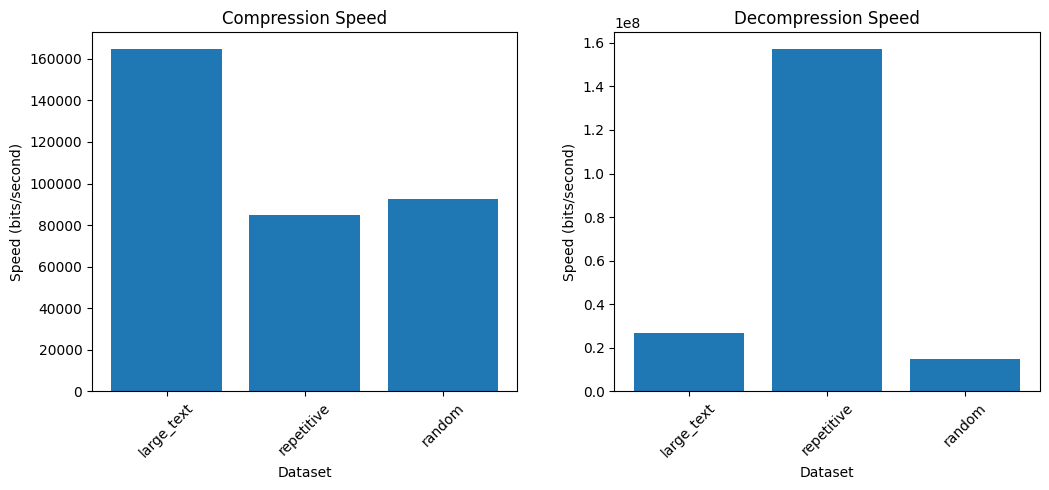

large_text:
  Compression Ratio: 1.19
  Compression Speed: 164536.73 bits/second
  Decompression Speed: 26633948.81 bits/second

repetitive:
  Compression Ratio: 18.16
  Compression Speed: 84871.34 bits/second
  Decompression Speed: 156999241.46 bits/second

random:
  Compression Ratio: 0.63
  Compression Speed: 92676.27 bits/second
  Decompression Speed: 14758243.56 bits/second



In [116]:
import matplotlib.pyplot as plt

# Collect data
names = []
compression_ratios = []
compression_speeds = []
decompression_speeds = []

for name, data in datasets:
    results = evaluate_deflate(data)
    names.append(name)
    compression_ratios.append(results['compression_ratio'])
    compression_speeds.append(results['compression_speed'])
    decompression_speeds.append(results['decompression_speed'])

plt.figure(figsize=(15, 5))

# Compression Ratio
plt.subplot(131)
plt.bar(names, compression_ratios)
plt.title('Compression Ratio')
plt.xlabel('Dataset')
plt.ylabel('Ratio')
plt.xticks(rotation=45)
y_ticks = np.arange(0, 20, 1)
plt.yticks(y_ticks)

# Compression Speed
plt.subplot(132)
plt.bar(names, compression_speeds)
plt.title('Compression Speed')
plt.xlabel('Dataset')
plt.ylabel('Speed (bits/second)')
plt.xticks(rotation=45)

# Decompression Speed
plt.subplot(133)
plt.bar(names, decompression_speeds)
plt.title('Decompression Speed')
plt.xlabel('Dataset')
plt.ylabel('Speed (bits/second)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

for name, ratio, comp_speed, decomp_speed in zip(names, compression_ratios, compression_speeds, decompression_speeds):
    print(f"{name}:")
    print(f"  Compression Ratio: {ratio:.2f}")
    print(f"  Compression Speed: {comp_speed:.2f} bits/second")
    print(f"  Decompression Speed: {decomp_speed:.2f} bits/second")
    print()

In [59]:
randstring = ''.join(random.choices(string.ascii_letters, k=100))
randstring

'rqaZIndwgVhqpqIWPqGmPEHnMUUhqqkFJmvxAYxljPlhItEuQfrZyxEteLYqUlrmbdugLYQaCXDLRbqLZhRDvAhFTCfiYfyPenpc'

In [157]:
st = '''
The sun rises and the sun sets the stars shine and the stars fade the waves crash and the waves retreat day after day the cycle repeats life grows and life rests birds fly and birds return the rhythm of nature never stops never ends always in motion always the same the sun rises and the sun sets the stars shine and the stars fade the waves crash and the waves retreat day after day the cycle repeats life grows and life rests birds fly and birds return the rhythm of nature never stops never ends always in motion always the same the sun rises and the sun sets the stars shine and the stars fade the waves crash and the waves retreat day after day the cycle repeats life grows and life rests birds fly and birds return the rhythm of nature never stops never ends always in motion always the same the sun rises and the sun sets the stars shine and the stars fade the waves crash and the waves retreat day after day the cycle repeats life grows and life rests birds fly and birds return the rhythm of nature never stops never ends always in motion always the same the sun rises and the sun sets the stars shine and the stars fade the waves crash and the waves retreat day after day the cycle repeats life grows and life rests birds fly and birds return the rhythm of nature never stops never ends always in motion always the same
'''
file = open("large_text2.txt", "r").read()
defl, tree = deflate_compress(st)

In [158]:
huff, root = huffman_encoding(st)

In [163]:
orglen = len(st*8)
defllen = len(defl)
hufflen = len(huff)
defl_cr = orglen / defllen
huff_cr = orglen / hufflen

In [172]:
defl_cr

3.7625441696113073

In [173]:
huff_cr 

2.0382848392036754

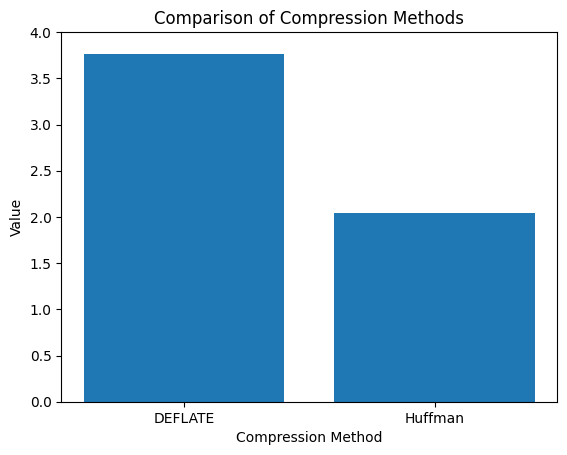

In [169]:
methods = ['DEFLATE', 'Huffman']
values = [3.762, 2.038]

plt.bar(methods, values)

plt.xlabel('Compression Method')
plt.ylabel('Value')
plt.title('Comparison of Compression Methods')
plt.ylim(0, 4)
plt.show()